In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# save the plot data
def get_sizes(days, data):
    week = int(days / 7) + 1
    remain = days % 7
    df = data[(data['week'] < week) | ((data['week'] == week) & (data['day_of_week'] <= remain))]
    df = df.groupby(['work_flow', 'week', 'day_of_week']).agg({'size': np.sum})

    all_sizes = {}
    for i in range(5):
        all_sizes[i] = df.loc[i]['size'].values
    return all_sizes

sizes20 = get_sizes(20, data)
sizes105 = get_sizes(105, data)

# plot figures
def plot_size_vs_days(period, total_size):
    plt.figure(figsize = (16,9))
    colors = ['deepskyblue', 'darkorange', 'deeppink', 'mediumseagreen', 'blueviolet']
    for i in range(5):
        plt.plot(range(1, period+1), total_size[i], colors[i], label='Work Flow '+str(i))
    plt.ylabel('Total Backup Size (GB)', fontsize = 18)
    plt.xlabel('Day Periods', fontsize = 18)
    plt.title('Total Backup Size in '+str(period)+' Days', fontsize = 23)
    plt.axis([0,period+1,0,12])
    plt.legend(loc = 'upper right')
    plt.show()

# 20 periods
plot_size_vs_days(20, sizes20)
# 105 periods
plot_size_vs_days(105, sizes105)


<Figure size 1600x900 with 1 Axes>

<Figure size 1600x900 with 1 Axes>

Q2 a(i)

,fold,train_rmse,test_rmse
0,0,0.103243,0.106718
1,1,0.103967,0.100185
2,2,0.103226,0.106850
3,3,0.103946,0.100367
4,4,0.103195,0.107116
5,5,0.103938,0.100445
6,6,0.103203,0.107050
7,7,0.103936,0.100467
8,8,0.103201,0.107074
9,9,0.103992,0.099947


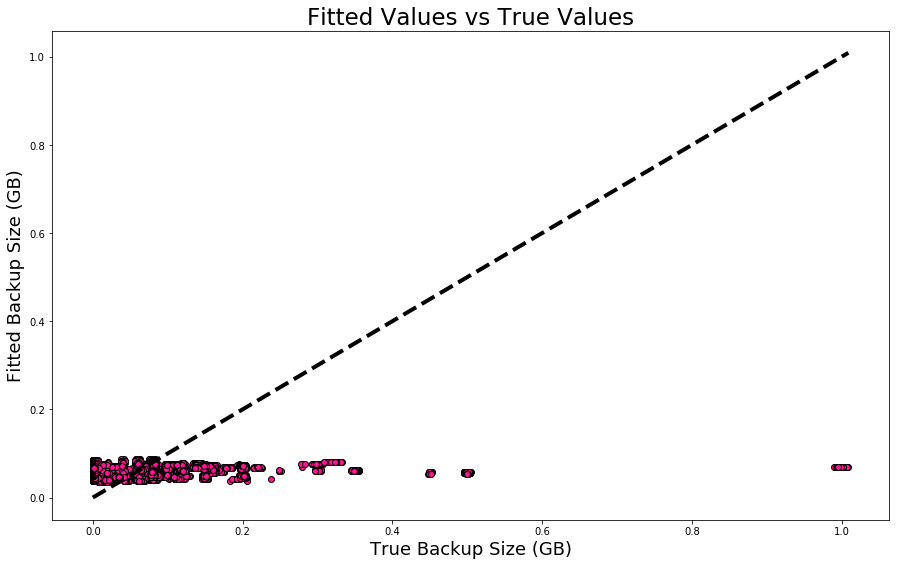

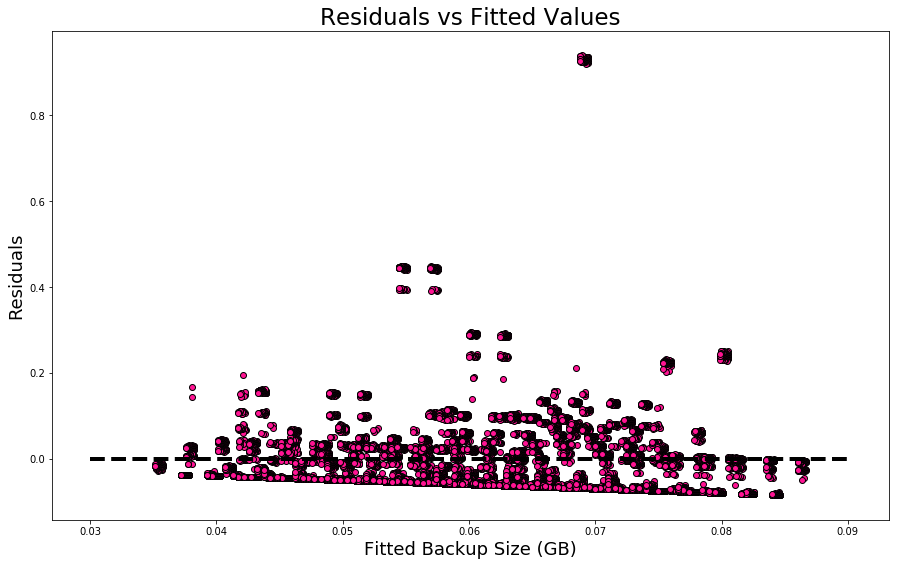

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn import linear_model
import matplotlib.pyplot as plt
from IPython.display import display


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# train and fit linear regression model
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

lr = linear_model.LinearRegression()
kf = KFold(n_splits=10, shuffle=False)
best_param = None
best_rmse = float("inf") 
fold = [i for i in range(10)]
train_rmses = []
test_rmses = []

for train_index, test_index in kf.split(input_arr):
    train_in = [input_arr[i] for i in train_index]
    train_out = [output_arr[i] for i in train_index]
    test_in = [input_arr[i] for i in test_index]
    test_out = [output_arr[i] for i in test_index]
    
    lr.fit(train_in, train_out)
    
    test_pre = lr.predict(test_in)
    train_pre = lr.predict(train_in)
    
    train_rmse = rmse(train_pre, train_out)
    test_rmse = rmse(test_pre, test_out)
    
    if ((train_rmse + test_rmse) < best_rmse):
        best_param = lr.get_params()

    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)

df = pd.DataFrame({
    'fold' : fold,
    'train_rmse' : train_rmses,
    'test_rmse' : test_rmses
}, columns = ['fold', 'train_rmse', 'test_rmse'])
# RMSE
display(df)

lr.set_params(**best_param)
all_pre = lr.predict(input_arr)
residuals = np.subtract(output_arr, all_pre)

# plot fitted values vs true values
plt.figure(figsize=(15,9))
plt.scatter(output_arr, all_pre, color='deeppink', edgecolors='k')
plt.plot([output_arr.min(), output_arr.max()], [output_arr.min(), output_arr.max()], 'k--', lw=4)
plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
plt.xlabel('True Backup Size (GB)', fontsize = 18)
plt.title('Fitted Values vs True Values', fontsize = 23)
plt.show()

# plot residuals vs fitted values
plt.figure(figsize=(15,9))
plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
plt.plot([0.03, 0.09], [0, 0], 'k--', lw=4)
plt.ylabel('Residuals', fontsize = 18)
plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
plt.title('Residuals vs Fitted Values', fontsize = 23)
plt.show()


Q2 a(ii)

,fold,train_rmse,test_rmse
0,0,0.990916,1.024267
1,1,0.997861,0.961560
2,2,0.990749,1.025531
3,3,0.997666,0.963311
4,4,0.990454,1.028085
5,5,0.997588,0.964062
6,6,0.990527,1.027456
7,7,0.997569,0.964267
8,8,0.990511,1.027685
9,9,0.998099,0.959281


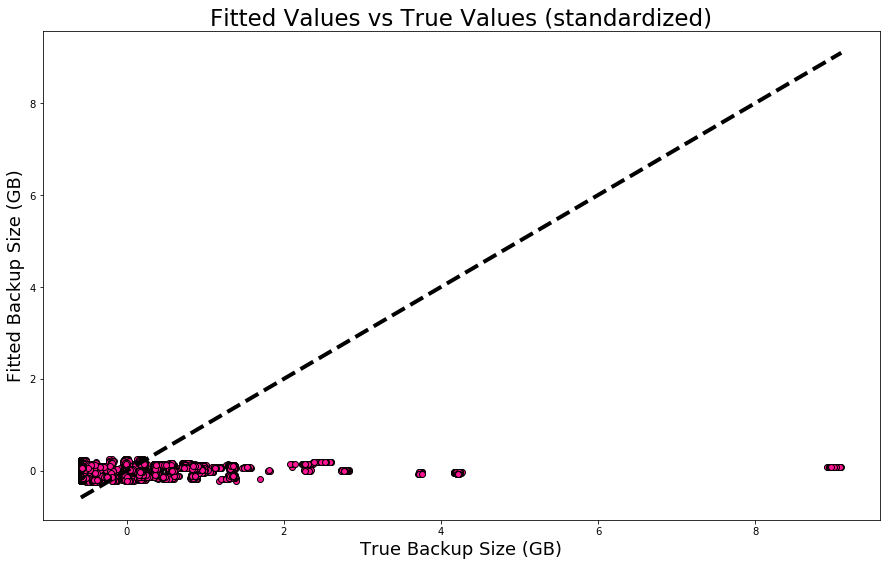

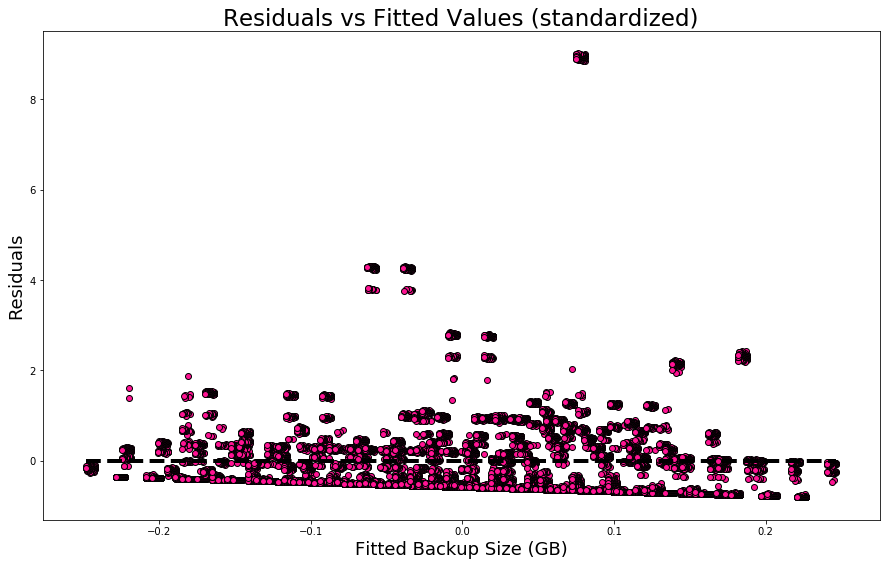

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# train and fit linear regression model
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

# standardization
scaler = StandardScaler()
input_arr = scaler.fit_transform(input_arr)
output_arr = scaler.fit_transform(output_arr.reshape(-1, 1))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

lr = linear_model.LinearRegression()
kf = KFold(n_splits=10, shuffle=False)
best_param = None
best_rmse = float("inf") 
fold = [i for i in range(10)]
train_rmses = []
test_rmses = []

for train_index, test_index in kf.split(input_arr):
    train_in = [input_arr[i] for i in train_index]
    train_out = [output_arr[i] for i in train_index]
    test_in = [input_arr[i] for i in test_index]
    test_out = [output_arr[i] for i in test_index]
    
    lr.fit(train_in, train_out)
    
    test_pre = lr.predict(test_in)
    train_pre = lr.predict(train_in)
    
    train_rmse = rmse(train_pre, train_out)
    test_rmse = rmse(test_pre, test_out)
    
    if ((train_rmse + test_rmse) < best_rmse):
        best_param = lr.get_params()

    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)

df = pd.DataFrame({
    'fold' : fold,
    'train_rmse' : train_rmses,
    'test_rmse' : test_rmses
}, columns = ['fold', 'train_rmse', 'test_rmse'])
# RMSE
display(df)

lr.set_params(**best_param)
all_pre = lr.predict(input_arr)
residuals = np.subtract(output_arr, all_pre)

# plot fitted values vs true values
plt.figure(figsize=(15,9))
plt.scatter(output_arr, all_pre, color='deeppink', edgecolors='k')
plt.plot([output_arr.min(), output_arr.max()], [output_arr.min(), output_arr.max()], 'k--', lw=4)
plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
plt.xlabel('True Backup Size (GB)', fontsize = 18)
plt.title('Fitted Values vs True Values (standardized)', fontsize = 23)
plt.show()

# plot residuals vs fitted values
plt.figure(figsize=(15,9))
plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
plt.ylabel('Residuals', fontsize = 18)
plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
plt.title('Residuals vs Fitted Values (standardized)', fontsize = 23)
plt.show()

Q2 a(iii)

D:\Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


use f_regression:
(18588, 3)
[1 2 3]
use mutual_info_regression:
(18588, 3)
[2 3 4]
after f_regression:


,fold,train_rmse,test_rmse
0,0,0.990921,1.024132
1,1,0.997869,0.961420
2,2,0.990750,1.025524
3,3,0.997668,0.963290
4,4,0.990455,1.028083
5,5,0.997589,0.964064
6,6,0.990529,1.027430
7,7,0.997570,0.964248
8,8,0.990517,1.027589
9,9,0.998100,0.959228


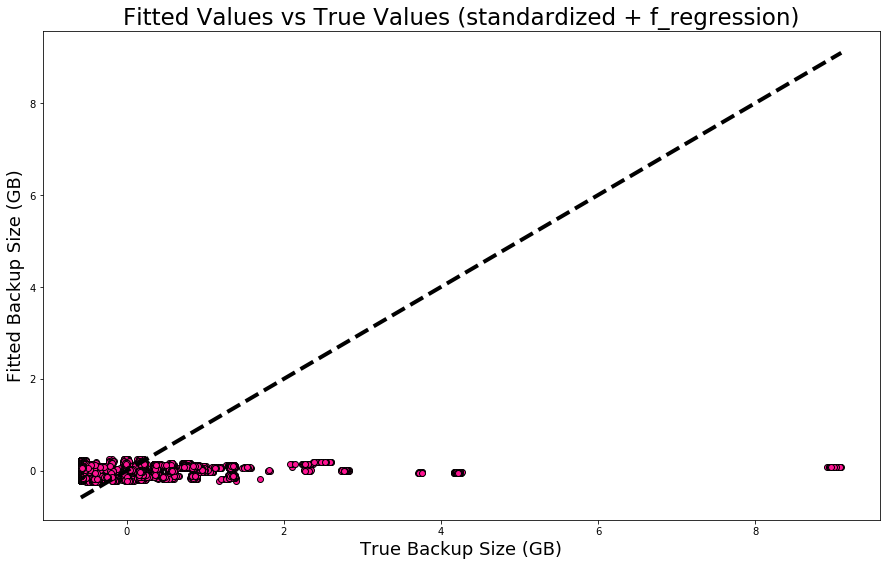

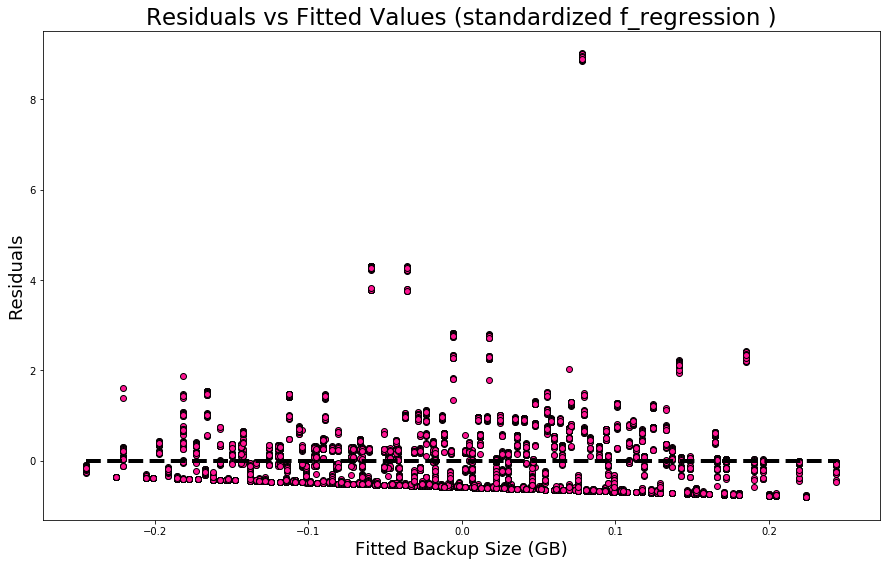

after mutual_info_regression:


,fold,train_rmse,test_rmse
0,0,0.991888,1.025784
1,1,0.999000,0.961580
2,2,0.991707,1.027262
3,3,0.998791,0.963534
4,4,0.991408,1.029864
5,5,0.998724,0.964186
6,6,0.991500,1.029055
7,7,0.998700,0.964421
8,8,0.991464,1.029416
9,9,0.999230,0.959415


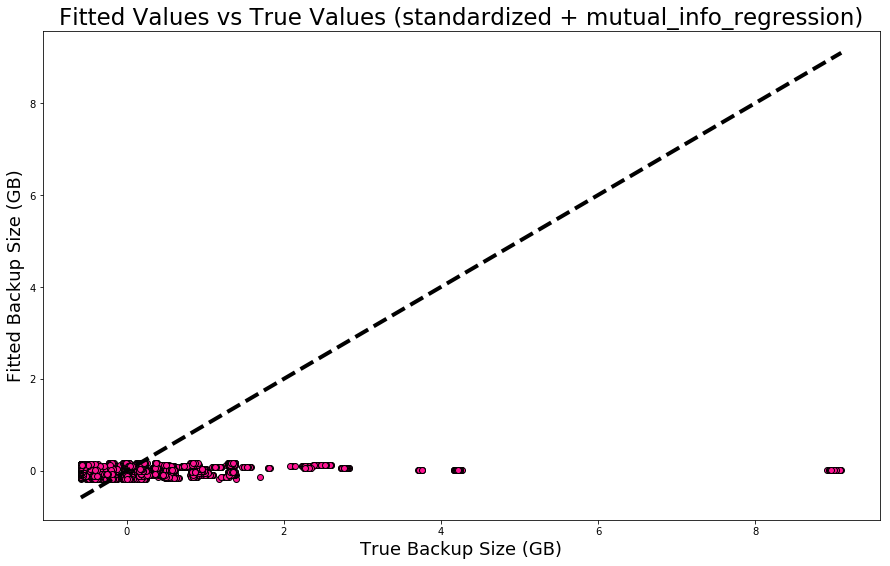

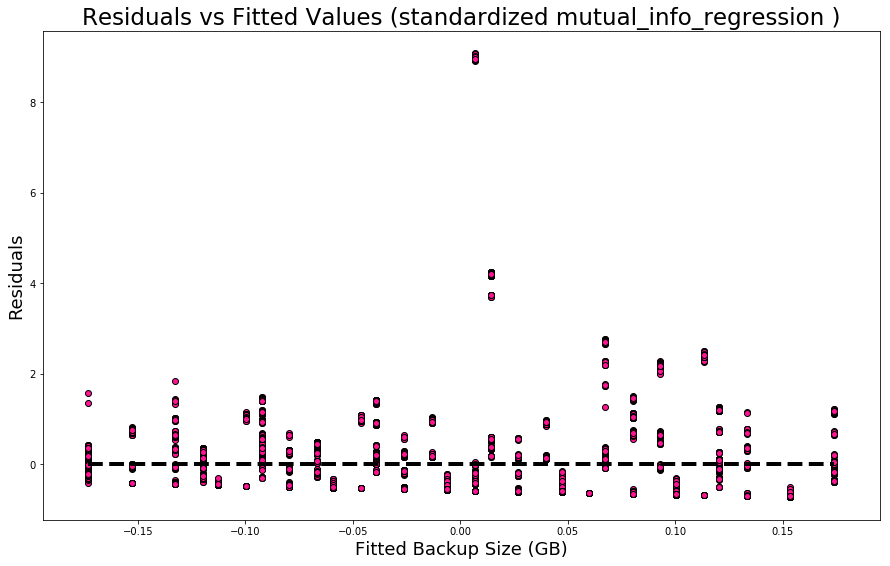

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

# standardize input, output
scaler = StandardScaler()
input_arr = scaler.fit_transform(input_arr)
output_arr = scaler.fit_transform(output_arr.reshape(-1, 1))

methods = ['f_regression', 'mutual_info_regression']
def select_features(method, method_str):
    select = SelectKBest(method, k=3).fit(input_arr, output_arr)
    input_arr_new = select.transform(input_arr)
    print ('use '+method_str+':')
    print (input_arr_new.shape)
    selected_features = select.get_support(True)
    print (selected_features)
    return input_arr_new

# 1 Use f_regression to select three most important variables
input_arr_new_f_regression = select_features(f_regression, methods[0])
# 2 Use mutual_info_regression to select three most important variables
input_arr_new_mutual_info_regression = select_features(mutual_info_regression, methods[1])

# train and fit new linear regression models
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def linear_regression_model(input_arr, method_str):
    lr = linear_model.LinearRegression()
    kf = KFold(n_splits=10, shuffle=False)
    best_param = None
    best_rmse = float("inf") 
    fold = [i for i in range(10)]
    train_rmses = []
    test_rmses = []

    for train_index, test_index in kf.split(input_arr):
        train_in = [input_arr[i] for i in train_index]
        train_out = [output_arr[i] for i in train_index]
        test_in = [input_arr[i] for i in test_index]
        test_out = [output_arr[i] for i in test_index]
    
        lr.fit(train_in, train_out)
    
        test_pre = lr.predict(test_in)
        train_pre = lr.predict(train_in)
    
        train_rmse = rmse(train_pre, train_out)
        test_rmse = rmse(test_pre, test_out)
    
        if ((train_rmse + test_rmse) < best_rmse):
            best_param = lr.get_params()

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    df = pd.DataFrame({
        'fold' : fold,
        'train_rmse' : train_rmses,
        'test_rmse' : test_rmses
    }, columns = ['fold', 'train_rmse', 'test_rmse'])
    # RMSE
    print ('after '+method_str+':')
    display(df)

    lr.set_params(**best_param)
    all_pre = lr.predict(input_arr)
    residuals = np.subtract(output_arr, all_pre)

    # plot fitted values vs true values
    plt.figure(figsize=(15,9))
    plt.scatter(output_arr, all_pre, color='deeppink', edgecolors='k')
    plt.plot([output_arr.min(), output_arr.max()], [output_arr.min(), output_arr.max()], 'k--', lw=4)
    plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
    plt.xlabel('True Backup Size (GB)', fontsize = 18)
    plt.title('Fitted Values vs True Values (standardized + '+method_str+')', fontsize = 23)
    plt.show()

    # plot residuals vs fitted values
    plt.figure(figsize=(15,9))
    plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
    plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
    plt.ylabel('Residuals', fontsize = 18)
    plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
    plt.title('Residuals vs Fitted Values (standardized '+method_str+' )', fontsize = 23)
    plt.show()
    
# 1 after using f_regression 
linear_regression_model(input_arr_new_f_regression, methods[0])
# 2 after using mutual_info_regression
linear_regression_model(input_arr_new_mutual_info_regression, methods[1])

In [ ]:
Q 2a(iv)

,combine,mean_train_rmse,mean_test_rmse
0,1,0.103585,1.036219e-01
1,2,0.103580,8.495538e+09
2,3,0.102152,1.022040e-01
3,4,0.102148,1.361102e+10
4,5,0.102361,1.024157e-01
5,6,0.102355,7.365544e+09
6,7,0.100906,1.009696e-01
7,8,0.100919,1.024759e+10
8,9,0.091337,9.133412e-02
9,10,0.091333,1.184974e+10


The best combination is: 30
The best mean_train_rmse is: 0.08833724075452494, and the best mean_test_rmse is: 0.08836964226225547
The second best combination is: 22
The second best mean_train_rmse is: 0.08833631755164509, and the second best mean_test_rmse is: 0.08837068225261673
The third best combination is: 14
The third best mean_train_rmse is: 0.08833825894684874, and the third best mean_test_rmse is: 0.08837323909537456


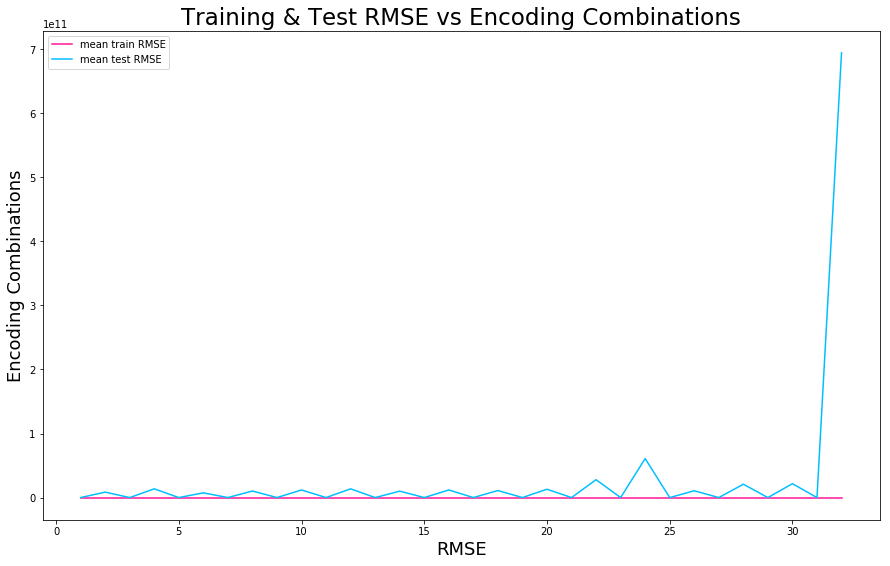

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder

# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

# 1 use scalar encoding method
def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1) encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2) encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3) encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

# 2 use one-hot encoding method
def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

# calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

lr = linear_model.LinearRegression()
kf = KFold(n_splits=10, shuffle=False)

train_rmses_means = []
test_rmses_means = []
combines = [i + 1 for i in range(32)]

for combine in range(32):
    # 00000~11111 (0~31) using bit operation
    one_hot_pos = []
    for pos in range(5):
        if ((combine >> pos) & 1) == 1:
            one_hot_pos.append(pos)
    tranformed_input = one_hot_encoding(input_arr, one_hot_pos)
    
    train_rmses = []
    test_rmses = []

    for train_index, test_index in kf.split(tranformed_input):
        train_in = [tranformed_input[i] for i in train_index]
        train_out = [output_arr[i] for i in train_index]
        test_in = [tranformed_input[i] for i in test_index]
        test_out = [output_arr[i] for i in test_index]

        lr.fit(train_in, train_out)

        test_pre = lr.predict(test_in)
        train_pre = lr.predict(train_in)

        train_rmse = rmse(train_pre, train_out)
        test_rmse = rmse(test_pre, test_out)

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    train_rmses_means.append(np.mean(train_rmses))
    test_rmses_means.append(np.mean(test_rmses))

df = pd.DataFrame({
    'combine' : combines,
    'mean_train_rmse' : train_rmses_means,
    'mean_test_rmse' : test_rmses_means
}, columns = ['combine', 'mean_train_rmse', 'mean_test_rmse'])

display(df)
train_rmses = df['mean_train_rmse'].values
test_rmses = df['mean_test_rmse'].values

# find combination with best performance
best_combine = None
second_best_combine = None
third_best_combine = None
best_mean_rmses = float("inf") 
second_best_mean_rmses = float("inf")
third_best_mean_rmses = float("inf")
for i in range(len(train_rmses)):
    if (train_rmses[i]+test_rmses[i]<best_mean_rmses):
        third_best_mean_rmses = second_best_mean_rmses
        third_best_combine = second_best_combine
        second_best_mean_rmses = best_mean_rmses
        second_best_combine = best_combine
        best_mean_rmses = train_rmses[i] + test_rmses[i]
        best_combine = i
    elif (train_rmses[i]+test_rmses[i]<second_best_mean_rmses):
        third_best_mean_rmses = second_best_mean_rmses
        third_best_combine = second_best_combine
        second_best_mean_rmses = train_rmses[i] + test_rmses[i]
        second_best_combine = i
    elif (train_rmses[i]+test_rmses[i]<third_best_mean_rmses):
        third_best_mean_rmses = train_rmses[i] + test_rmses[i]
        third_best_combine = i

print ('The best combination is: '+str(best_combine))
print ('The best mean_train_rmse is: '+str(train_rmses[best_combine])+', and the best mean_test_rmse is: '+str(test_rmses[best_combine]))
print ('The second best combination is: '+str(second_best_combine))
print ('The second best mean_train_rmse is: '+str(train_rmses[second_best_combine])+', and the second best mean_test_rmse is: '+str(test_rmses[second_best_combine]))
print ('The third best combination is: '+str(third_best_combine))
print ('The third best mean_train_rmse is: '+str(train_rmses[third_best_combine])+', and the third best mean_test_rmse is: '+str(test_rmses[third_best_combine]))

# plot training RMSE and test RMSE
plt.figure(figsize=(15,9))
plt.plot(range(1,33), train_rmses, 'deeppink', label='mean train RMSE')
plt.plot(range(1,33), test_rmses, 'deepskyblue', label='mean test RMSE')
plt.ylabel('Encoding Combinations', fontsize = 18)
plt.xlabel('RMSE', fontsize = 18)
plt.title('Training & Test RMSE vs Encoding Combinations', fontsize = 23)
plt.legend(loc='upper left')
plt.show()

Q2 a(v)

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def find_optimal_combination(input_arr, alg, kf_split=10, num_combines=32):
    # return values of this function
    best_test_rmse = float("inf")
    best_combination = 0
    
    kf = KFold(n_splits=kf_split, shuffle=False)
    for combine in range(num_combines):
        # 00000~11111 (0~31) using bit operation
        one_hot_pos = []
        for pos in range(5):
            if ((combine >> pos) & 1) == 1:
                one_hot_pos.append(pos)
        tranformed_input = one_hot_encoding(input_arr, one_hot_pos)

        test_rmses = []
        
        for train_index, test_index in kf.split(tranformed_input):
            
            train_in = [tranformed_input[i] for i in train_index]
            train_out = [output_arr[i] for i in train_index]
            test_in = [tranformed_input[i] for i in test_index]
            test_out = [output_arr[i] for i in test_index]

            alg.fit(train_in, train_out)
            test_pre = alg.predict(test_in)

            test_rmses.append(rmse(test_pre, test_out))

        mean_test_rmse = np.mean(test_rmses)
        
        if mean_test_rmse < best_test_rmse:
            best_test_rmse = mean_test_rmse
            best_combination = combine

    return best_combination, best_test_rmse

def combinaton_trans(combine):
    variables = ['week','day_of_week','start_time','work_flow','file_name']
    use_one_hot = []
    use_scalar = []
    for pos in range(5):
            if ((combine >> pos) & 1) == 1:
                use_one_hot.append(variables[pos])
            else:
                use_scalar.append(variables[pos])
    return 'use_one_hot: ' + str(use_one_hot) + '\nuse_scalar: ' + str(use_scalar)

# Ridge Regularizer & Lasso Regularizer
def Ridge_Lasso_Regularizer(name):
    print('using ' + name)
    best_combine = None
    lowest_rmse = float("inf")
    optimal_alpha = 1
    for alpha in [0.001, 0.01, .1, .5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        reg = None
        if name == 'Ridge Regularizer':
            reg = linear_model.Ridge (alpha = alpha)
        else:
            reg = linear_model.Lasso(alpha=alpha)
        best_combination, best_test_rmse = find_optimal_combination(input_arr, reg, kf_split=10, num_combines=32)
        if best_test_rmse < lowest_rmse:
            best_combine = best_combination
            lowest_rmse = best_test_rmse
            optimal_alpha = alpha

    print ('Optimal Combination:')
    print (combinaton_trans(best_combine)) 
    print ('Optimal Alpha: ' + str(optimal_alpha))
    print ('Optimal Test Rmse: ' + str(lowest_rmse))

    one_hot_pos = []
    for pos in range(5):
        if ((best_combine >> pos) & 1) == 1:
            one_hot_pos.append(pos)
    tranformed_input = one_hot_encoding(input_arr, one_hot_pos)

    alg = linear_model.Ridge (alpha = optimal_alpha)
    alg.fit(tranformed_input, output_arr)
    print ('estimated coefficients: ')
    print (str(alg.coef_))
    print ('-----------------------------------------')

Ridge_Lasso_Regularizer('Ridge Regularizer')
Ridge_Lasso_Regularizer('Lasso Regularizer')

# Elastic Net Regularizer:
print('using ' + 'Elastic Net Regularizer')
best_combine = None
lowest_rmse = float("inf")
optimal_alpha = .2
optimal_l1_ratio = 0.001
for alpha in [0.01, 0.1, 1, 10, 100]:
    for l1_ratio in [0.1, 0.5, 0.9]:
        reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        best_combination, best_test_rmse = find_optimal_combination(input_arr, reg, kf_split=10, num_combines=32)
        if best_test_rmse < lowest_rmse:
            best_combine = best_combination
            lowest_rmse = best_test_rmse
            optimal_alpha = alpha

print ('Optimal Combination:')
print (combinaton_trans(best_combine)) 
print ('Optimal Alpha1: ' + str(optimal_alpha * optimal_l1_ratio))
print ('Optimal Alpha2: ' + str(optimal_alpha * (1-optimal_l1_ratio)))
print ('Optimal Test Rmse: ' + str(lowest_rmse))

one_hot_pos = []
for pos in range(5):
    if ((best_combine >> pos) & 1) == 1:
        one_hot_pos.append(pos)
tranformed_input = one_hot_encoding(input_arr, one_hot_pos)

alg = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
alg.fit(tranformed_input, output_arr)
print ('estimated coefficients: ')
print (str(alg.coef_))
print ('-----------------------------------------')

# using un-regularized best model
print('using un-regularized best model')

best_combine = 22
one_hot_pos = []
for pos in range(5):
    if ((best_combine >> pos) & 1) == 1:
        one_hot_pos.append(pos)
tranformed_input = one_hot_encoding(input_arr, one_hot_pos)

lr = linear_model.LinearRegression()
lr.fit(tranformed_input, output_arr)

print ('Optimal Combination:')
print (combinaton_trans(best_combine))
print ('Optimal Test Rmse: 0.0883701294703')
print ('estimated coefficients: ')
print (str(lr.coef_))
print ('-----------------------------------------')

using Ridge Regularizer
Optimal Combination:
use_one_hot: ['day_of_week', 'start_time', 'work_flow']
use_scalar: ['week', 'file_name']
Optimal Alpha: 5
Optimal Test Rmse: 0.0883677380035068
estimated coefficients: 
[ 3.92371018e-02 -1.28385492e-02 -2.02296713e-02 -5.23861235e-03
 -5.69522387e-03  3.27107576e-03  1.49387908e-03 -2.01731751e-02
 -2.10260133e-02  7.77904202e-03  3.34016216e-02 -1.98635056e-03
  2.00487535e-03  3.88772567e-02 -1.36944804e-02 -4.01480968e-02
 -5.71822376e-02  7.21475581e-02  1.12198388e-05  5.87765230e-05]
-----------------------------------------
using Lasso Regularizer
Optimal Combination:
use_one_hot: ['week', 'day_of_week', 'start_time', 'work_flow', 'file_name']
use_scalar: []
Optimal Alpha: 0.001
Optimal Test Rmse: 0.0888033150298335
estimated coefficients: 
[-7.89378817e-04 -3.97987478e-05  3.50273477e-04 -3.50408384e-04
  3.30577871e-04 -2.13416253e-04  8.20827052e-06  8.23510472e-04
  1.26465676e-04  1.23745607e-04 -5.69967187e-04  7.22425684e-04
 

Q2 b

In [ ]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
from sklearn.tree import export_graphviz

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load data
data = pd.read_csv('network_backup_dataset.csv').values
X, y = data[:, :-2], data[:, -2]
days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
data[:, 1] = [days[d] for d in data[:, 1]]
data[:, 3] = [int(re.sub(r'work_flow_', '', wf)) for wf in data[:, 3]]
data[:, 4] = [int(re.sub(r'File_', '', f)) for f in data[:, 4]]
print('Number of rows of data: ' + str(data.shape[0]))
print('-------------------------------------')

# i
print('Regressor Info:\nNumber of trees: 20\nDepth of each tree: 4\nBootstrap: True\nMaximum number of features: 5\n')
rf = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, bootstrap=True, oob_score=True)
scoring = {'mse':make_scorer(mean_squared_error)}
cv = cross_validate(rf, X, y, cv=10, return_train_score=True, scoring=scoring)
print('Average Training RMSE: ' + str(math.sqrt(cv['train_mse'].mean())))
print('Average Test RMSE: ' + str(math.sqrt(cv['test_mse'].mean())))
rf.fit(X, y)
y_pred = rf.predict(X)
residual = y - y_pred
print('Out of Bag error: ' + str(rf.oob_score_))
train_rmse = np.sqrt(cv['train_mse'])
test_rmse = np.sqrt(cv['test_mse'])
print('Training RMSE for 10 folds:')
print(train_rmse)
print('Test RMSE for 10 folds:')
print(test_rmse)
print('-------------------------------------')

plt.figure()
plt.scatter(y, y_pred, c='r', s=6)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Fitted Values')
plt.title('Fitted values vs. True values')
plt.figure()
plt.scatter(y_pred, residual, c='y', s=6)
plt.plot([0, 1], [0, 0], color='navy', lw=2, linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. fitted values')

# ii
numTrees = 200
#gap = 10
numFeatures = 5
oobErrors = np.zeros((numFeatures, numTrees))
testRMSEs = np.zeros((numFeatures, numTrees))
for t in range(1, numTrees+1):
    print('Tree ' + str(t) + ':')
    for f in range(1, numFeatures+1):
        print(f)
        rf = RandomForestRegressor(n_estimators=t, max_features=f, max_depth=4, bootstrap=True, oob_score=True)
        cv = cross_validate(rf, X, y, cv=10, return_train_score=True, scoring=scoring)
        testRMSEs[f-1][t-1] = math.sqrt(cv['test_mse'].mean())
        rf.fit(X, y)
        oobErrors[f-1][t-1] = rf.oob_score_
moob = np.argmax(oobErrors)
roob, coob = moob//numTrees+1, moob%numTrees+1
mrmse = np.argmin(testRMSEs)
rrmse, crmse = mrmse//numTrees+1, mrmse%numTrees+1
print('Maximum OOB errors: ' + str(oobErrors[roob-1][coob-1]) + ' tree ' + str(coob) + ' feature ' + str(roob))
print('Minimum test RMSE: ' + str(testRMSEs[rrmse-1][crmse-1]) + ' tree ' + str(crmse) + ' feature ' + str(rrmse))

x = range(1, numTrees+1)
colors = 'bgrcmykw'

plt.figure()
for f in range(1, numFeatures+1):
    plt.plot(x, oobErrors[f-1], color=colors[f-1], lw=2, label=f)
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Error')
plt.title('Out of bag error vs. Number of trees')
plt.legend(loc="upper left")

plt.figure()
for f in range(1, numFeatures+1):
    plt.plot(x, testRMSEs[f-1], color=colors[f-1], lw=2, label=f)
plt.xlabel('Number of Trees')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs. Number of trees')
plt.legend(loc="upper right")
print('-------------------------------------')

# iii
bestNumTrees = 27
bestNumFeatures = 3
numTrees = 20
gap = 10
numImpurities = 6
oobErrors = np.zeros((numImpurities, numTrees))
testRMSEs = np.zeros((numImpurities, numTrees))
for t in range(1, numTrees+1):
    print('Tree ' + str(t) + ':')
    for i in range(1, numImpurities + 1):
        print(i)
        rf = RandomForestRegressor(n_estimators=t*gap, max_features=bestNumFeatures, max_depth=4, bootstrap=True, oob_score=True, min_impurity_decrease=1.0*(i-1)/25)
        cv = cross_validate(rf, X, y, cv=10, return_train_score=True, scoring=scoring)
        testRMSEs[i-1][t-1] = math.sqrt(cv['test_mse'].mean())
        rf.fit(X, y)
        oobErrors[i-1][t-1] = rf.oob_score_
moob = np.argmax(oobErrors)
roob, coob = moob//numTrees+1, moob%numTrees+1
mrmse = np.argmin(testRMSEs)
rrmse, crmse = mrmse//numTrees+1, mrmse%numTrees+1
print('Maximum OOB errors: ' + str(oobErrors[roob-1][coob-1]) + ' tree ' + str(coob) + ' min impurity decrease ' + str(roob))
print('Minimum test RMSE: ' + str(testRMSEs[rrmse-1][crmse-1]) + ' tree ' + str(crmse) + ' min impurity decrease ' + str(rrmse))

x = range(10, numTrees*gap+1, 10)
colors = 'bgrcmykw'

plt.figure()
for i in range(1, numImpurities+1):
    plt.plot(x, oobErrors[i-1], color=colors[i-1], lw=1, label=i)
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Error')
plt.title('Out of bag error vs. Number of trees')
plt.legend(loc="upper left")

plt.figure()
for i in range(1, numImpurities+1):
    plt.plot(x, testRMSEs[i-1], color=colors[i-1], lw=1, label=i)
plt.xlabel('Number of Trees')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs. Number of trees')
plt.legend(loc="upper right")
print('-------------------------------------')

# v
rf = RandomForestRegressor(n_estimators=bestNumTrees, max_features=3, max_depth=4, bootstrap=True, oob_score=True)
rf.fit(X, y)
tree = rf.estimators_[0]
y_pred = tree.predict(X)
export_graphviz(tree, out_file='rf.dot')

# Plot the results
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X[:, 1].tolist(), X[:, 4].tolist(), y, s=8, c="darkorange", marker='o', label='data')
ax.scatter(X[:, 1].tolist(), X[:, 4].tolist(), y_pred, s=8, c="cornflowerblue", marker='o', label='prediction')

ax.set_xlabel('Day of Week')
ax.set_ylabel('File Name')
ax.set_zlabel('Size of Backup (GB)')
plt.legend()
plt.show()

Number of rows of data: 18588
-------------------------------------
Regressor Info:
Number of trees: 20
Depth of each tree: 4
Bootstrap: True
Maximum number of features: 5

Average Training RMSE: 0.06020614751572168
Average Test RMSE: 0.06041042853728905
Out of Bag error: 0.6578642645301198
Training RMSE for 10 folds:
[0.06003556 0.06142141 0.0599918  0.06045676 0.06013859 0.05953411
 0.05998938 0.06035459 0.06015849 0.05996251]
Test RMSE for 10 folds:
[0.06752011 0.05290967 0.06737257 0.05233505 0.06742325 0.05283215
 0.06758863 0.05202664 0.06739458 0.0519964 ]
-------------------------------------
Tree 1:
1
2
3
4
5
Tree 2:
1
2
3
4
5
Tree 3:
1
2
3
4
5
Tree 4:
1
2
3
4
5
Tree 5:
1
2
3
4
5
Tree 6:
1
2
3
4
5
Tree 7:
1
2
3
4
5
Tree 8:
1
2
3
4
5
Tree 9:
1
2
3
4
5
Tree 10:
1
2
3
4
5
Tree 11:
1
2
3
4
5
Tree 12:
1
2
3
4
5
Tree 13:
1
2
3
4
5
Tree 14:
1
2
3
4
5
Tree 15:
1
2
3
4
5
Tree 16:
1
2
3
4
5
Tree 17:
1
2
3
4
5
Tree 18:
1
2
3
4
5
Tree 19:
1
2
3
4
5
Tree 20:
1
2
3
4
5
Tree 21:
1
2
3
4
5
Tr

Q2 c

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_x_y(activation):
    x_y = {}
    for hidden_units in range(10, 200, 20):
        reg = MLPRegressor(hidden_layer_sizes=(hidden_units, ), activation=activation)
        kf = KFold(n_splits=10, shuffle=False)
        
        test_rmses = []
        for train_index, test_index in kf.split(tranformed_input):
            train_in = [tranformed_input[i] for i in train_index]
            train_out = [output_arr[i] for i in train_index]
            test_in = [tranformed_input[i] for i in test_index]
            test_out = [output_arr[i] for i in test_index]
            reg.fit(train_in, train_out)
            test_pre = reg.predict(test_in)
            test_rmses.append(rmse(test_pre, test_out))
        
        x_y[hidden_units] = np.mean(test_rmses)
    return x_y

combine = 31
one_hot_pos = []
for pos in range(5):
    if ((combine >> pos) & 1) == 1:
        one_hot_pos.append(pos)
tranformed_input = one_hot_encoding(input_arr, one_hot_pos)

activation_x_y = {}
for activation in ['relu','logistic', 'tanh']:
    activation_x_y[activation] = get_x_y(activation)

# plot test RMSE vs number of hidden units
plt.figure(figsize=(15,9))
plt.plot(range(10, 200, 20), list(activation_x_y['relu'].values()), 'darkorange', label='activity function: relu')
plt.plot(range(10, 200, 20), list(activation_x_y['logistic'].values()), 'deepskyblue', label='activity function: logistic')
plt.plot(range(10, 200, 20), list(activation_x_y['tanh'].values()), 'deeppink', label='activity function: tanh')
plt.xlabel('Number of Hidden Units', fontsize=18)
plt.ylabel('Test RMSE', fontsize=18)
plt.title('Test RMSE vs Number of Hidden Units', fontsize=23)
plt.axis([0, 200, 0.02, 0.12])
plt.legend(loc='upper right')
plt.show()

# find optimal combination
min_y = float("inf")
optimal_com = None
for key in activation_x_y:
    x_y = activation_x_y[key]
    for x in x_y:
        if x_y[x] < min_y:
            min_y = x_y[x]
            optimal_com = (key, x)
print ('The best combination is:')
print (optimal_com)

reg = MLPRegressor(hidden_layer_sizes=(130, ), activation='relu')
reg.fit(tranformed_input, output_arr)
all_pre = reg.predict(tranformed_input)
residuals = np.subtract(output_arr, all_pre)
final_rmse = rmse(all_pre, output_arr)

# plot fitted values vs true values
plt.figure(figsize=(15,9))
plt.scatter(output_arr, all_pre, color='deeppink', edgecolors='k')
plt.plot([output_arr.min(), output_arr.max()], [output_arr.min(), output_arr.max()], 'k--', lw=4)
plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
plt.xlabel('True Backup Size (GB)', fontsize = 18)
plt.title('Fitted Values vs True Values (Neural Network Regression)', fontsize = 23)
plt.show()

# plot residuals vs fitted values
plt.figure(figsize=(15,9))
plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
plt.ylabel('Residuals', fontsize = 18)
plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
plt.title('Residuals vs Fitted Values (Neural Network Regression)', fontsize = 23)
plt.show()

<Figure size 1500x900 with 1 Axes>

The best combination is:
('relu', 170)


<Figure size 1500x900 with 1 Axes>

<Figure size 1500x900 with 1 Axes>

Q2 d(i)

workflow0
-----------------------------------------
RMSE of Work Flow 0: 0.02550659118047349


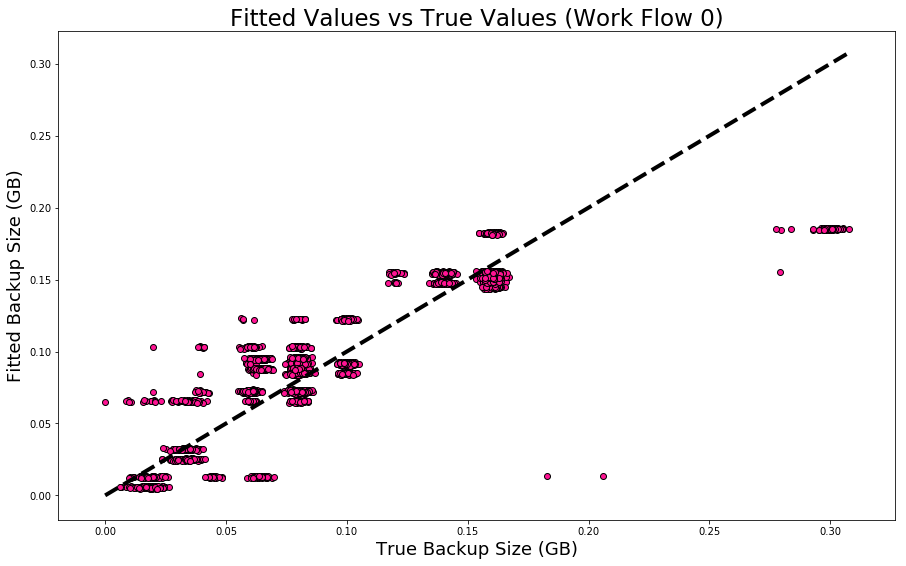

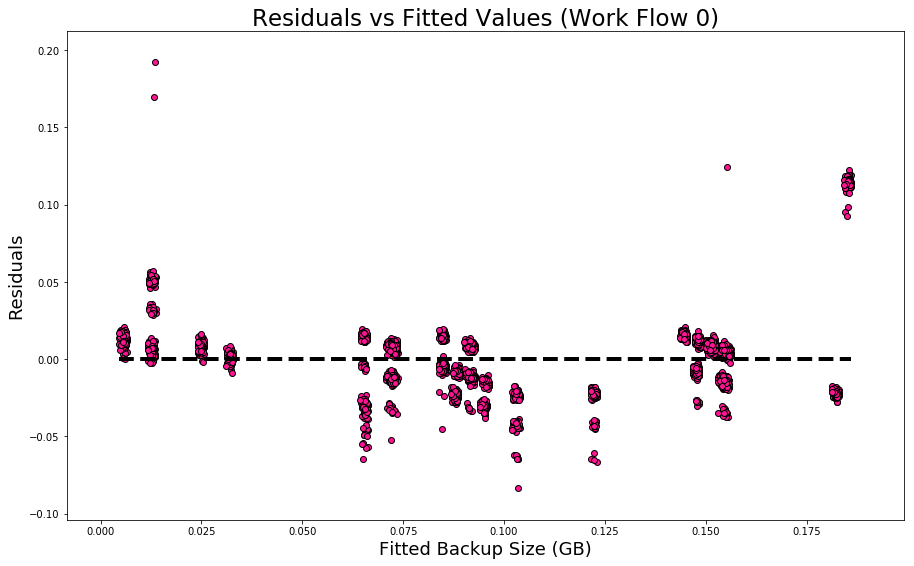

-----------------------------------------
workflow1
-----------------------------------------
RMSE of Work Flow 1: 0.11340572109857368


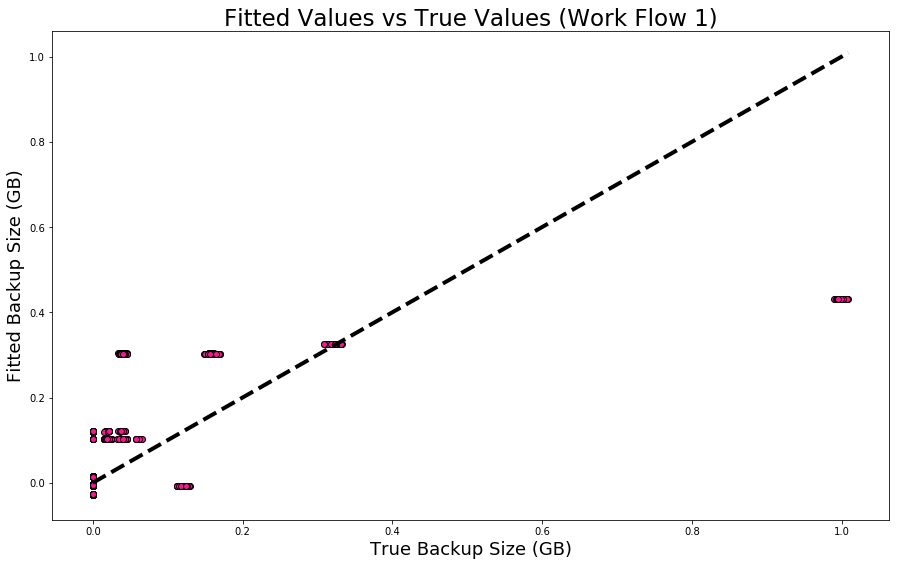

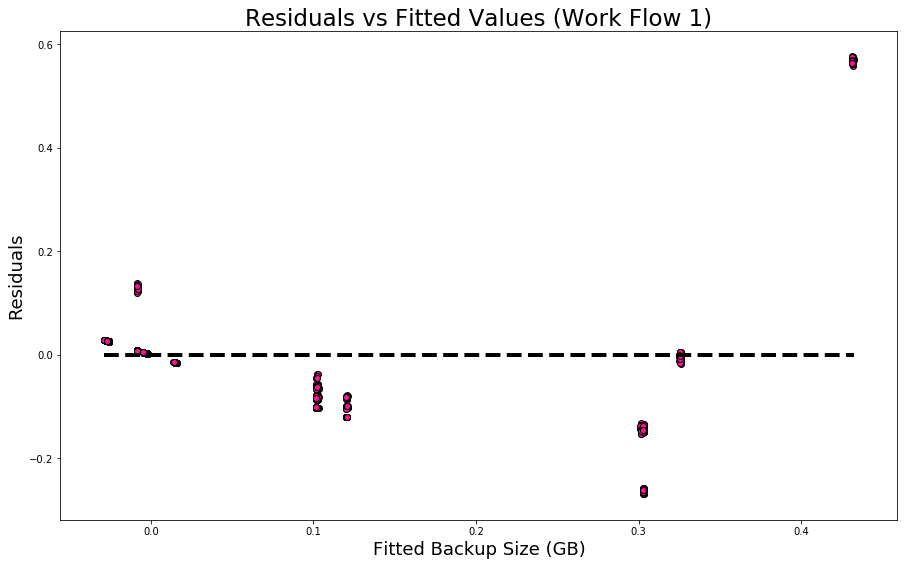

-----------------------------------------
workflow2
-----------------------------------------
RMSE of Work Flow 2: 0.030972718574691353


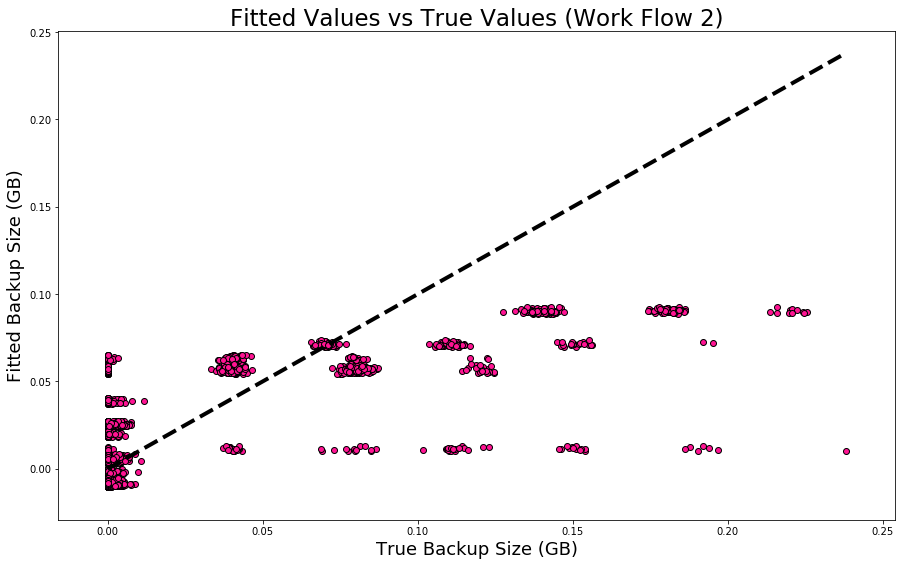

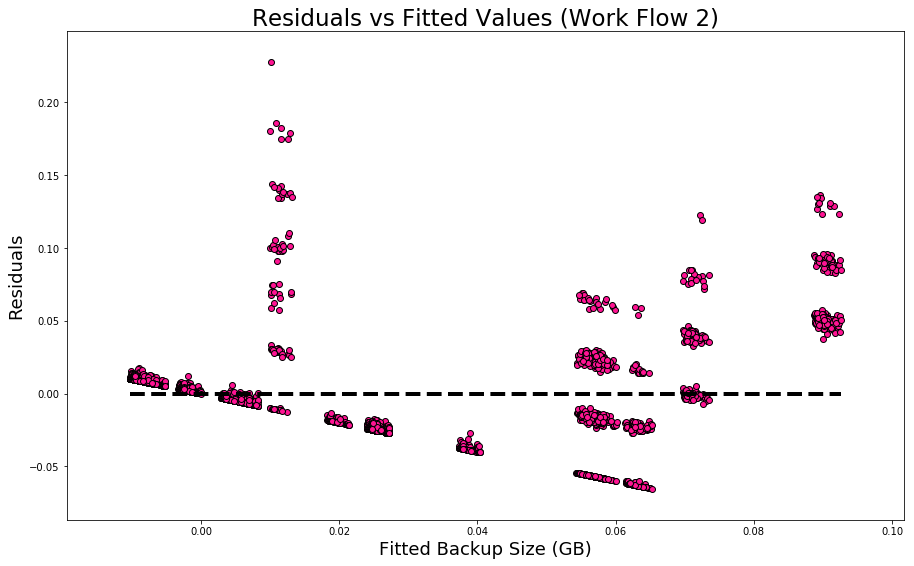

-----------------------------------------
workflow3
-----------------------------------------
RMSE of Work Flow 3: 0.005301629138189515


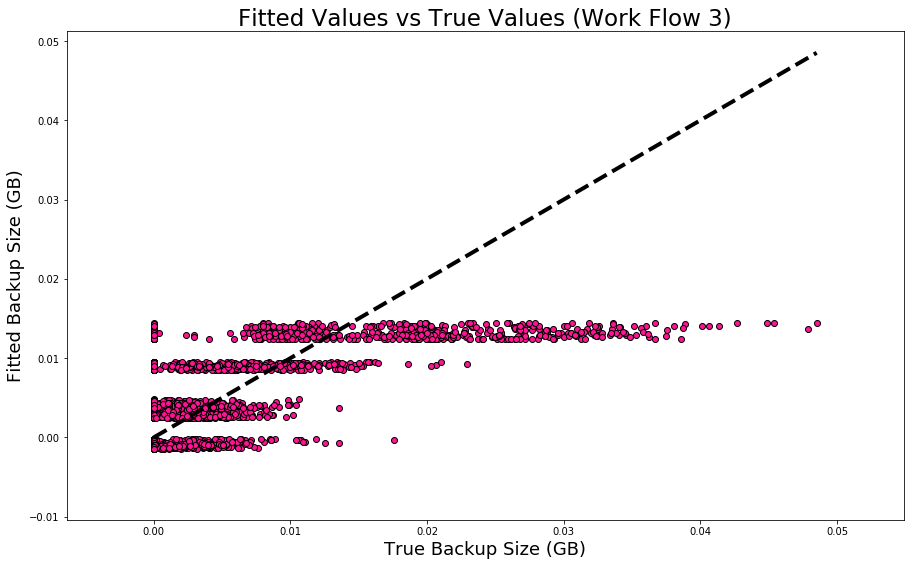

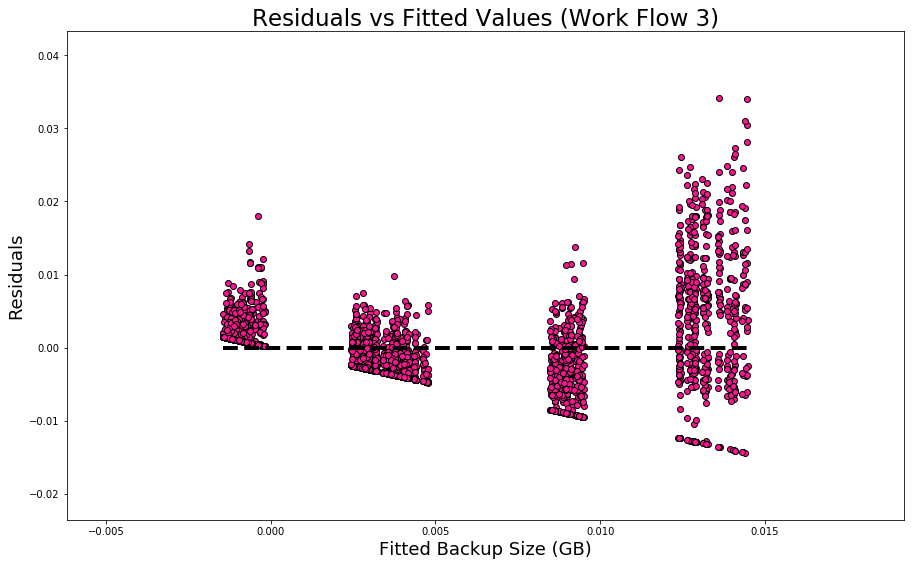

-----------------------------------------
workflow4
-----------------------------------------
RMSE of Work Flow 4: 0.054056561348179655


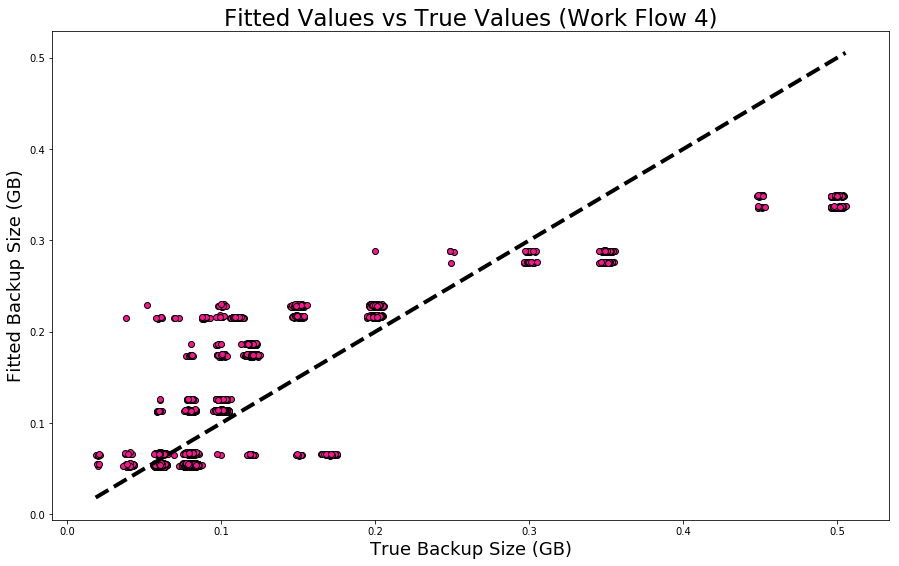

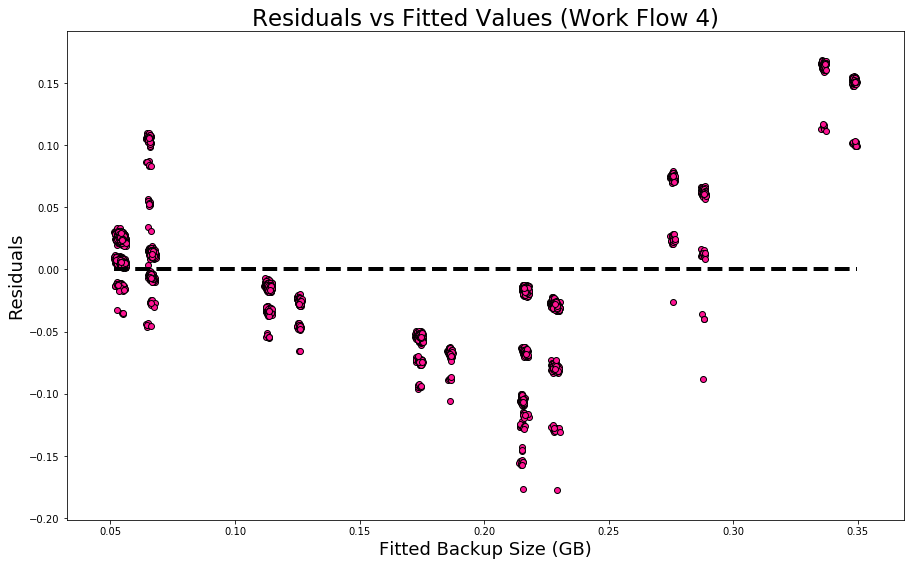

-----------------------------------------


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
map_workflow_input = {}
map_workflow_output = {}

for workflow in range(5):
    df = data[data['work_flow'] == workflow]
    df = df.drop('work_flow', 1, inplace = False)
    input_arr = []
    output_arr = []
    for row in range(len(df)):
        input_arr.append(df.iloc[row, 0:4].values)
    output_arr = df.loc[:, 'size'].values
    map_workflow_input[workflow] = input_arr
    map_workflow_output[workflow] = output_arr

def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Using linear regression model
for workflow in range(5):
    print ('workflow' + str(workflow))
    print ('-----------------------------------------')
    cur_input = map_workflow_input[workflow]
    cur_output = map_workflow_output[workflow]
    # one-hot-encoding
    best_combine = 14
    one_hot_pos = []
    for pos in range(5):
        if ((best_combine >> pos) & 1) == 1:
            one_hot_pos.append(pos)
    tranformed_cur_input = one_hot_encoding(cur_input, one_hot_pos)
    # Ridge regularizer
    reg = linear_model.Ridge (alpha = 5)
    # use 10-fold cross-validation to evaluate
    kf = KFold(n_splits=10, shuffle=False)
    best_param = None
    lowest_rmse = float('inf')
    
    for train_index, test_index in kf.split(tranformed_cur_input):
        train_in = [tranformed_cur_input[i] for i in train_index]
        train_out = [output_arr[i] for i in train_index]
        test_in = [tranformed_cur_input[i] for i in test_index]
        test_out = [output_arr[i] for i in test_index]

        reg.fit(train_in, train_out)
        test_pre = reg.predict(test_in)
        cur_rmse = rmse(test_pre, test_out)
        if (cur_rmse < lowest_rmse):
            lowest_rmse = cur_rmse
            best_param = reg.get_params()
    
    reg.set_params(**best_param)
    reg.fit(tranformed_cur_input, cur_output)
    all_pre = reg.predict(tranformed_cur_input)
    residuals = np.subtract(cur_output, all_pre)
    final_rmse = rmse(all_pre, cur_output)
    print ('RMSE of Work Flow '+str(workflow)+': '+str(final_rmse))
    
    # plot fitted values vs true values
    plt.figure(figsize=(15,9))
    plt.scatter(cur_output, all_pre, color='deeppink', edgecolors='k')
    plt.plot([cur_output.min(), cur_output.max()], [cur_output.min(), cur_output.max()], 'k--', lw=4)
    plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
    plt.xlabel('True Backup Size (GB)', fontsize = 18)
    plt.title('Fitted Values vs True Values (Work Flow '+str(workflow)+')', fontsize = 23)
    plt.show()

    # plot residuals vs fitted values
    plt.figure(figsize=(15,9))
    plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
    plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
    plt.ylabel('Residuals', fontsize = 18)
    plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
    plt.title('Residuals vs Fitted Values (Work Flow '+str(workflow)+')', fontsize = 23)
    plt.show()
    
    print ('-----------------------------------------')

Q2 d(ii)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
map_workflow_input = {}
map_workflow_output = {}

for workflow in range(5):
    df = data[data['work_flow'] == workflow]
    df = df.drop('work_flow', 1, inplace = False)
    input_arr = []
    output_arr = []
    for row in range(len(df)):
        input_arr.append(df.iloc[row, 0:4].values)
    output_arr = df.loc[:, 'size'].values
    map_workflow_input[workflow] = input_arr
    map_workflow_output[workflow] = output_arr

def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Using linear regression model
workflows = []
degrees = []
test_rmse = []
train_rmse = []

for workflow in range(5):
    print ('-----------------------------------------')
    cur_input = map_workflow_input[workflow]
    cur_output = map_workflow_output[workflow]
    
    for degree in range(1, 6, 1):
        print ('workflow' + str(workflow))
        print ('degree = ' + str(degree))
        poly = PolynomialFeatures(degree)
        best_combine = 14
        one_hot_pos = []
        for pos in range(5):
            if ((best_combine >> pos) & 1) == 1:
                one_hot_pos.append(pos)
        tranformed_cur_input = poly.fit_transform(one_hot_encoding(cur_input, one_hot_pos))

        reg = linear_model.Ridge (alpha = 5)

        kf = KFold(n_splits=10, shuffle=False)

        best_param = None
        lowest_rmse = float('inf')
        cur_train_rmse = []
        cur_test_rmse = []

        for train_index, test_index in kf.split(tranformed_cur_input):
            train_in = [tranformed_cur_input[i] for i in train_index]
            train_out = [output_arr[i] for i in train_index]
            test_in = [tranformed_cur_input[i] for i in test_index]
            test_out = [output_arr[i] for i in test_index]

            reg.fit(train_in, train_out)
            test_pre = reg.predict(test_in)
            cur_rmse = rmse(test_pre, test_out)
            if (cur_rmse < lowest_rmse):
                lowest_rmse = cur_rmse
                best_param = reg.get_params()
            cur_test_rmse.append(cur_rmse)
            cur_train_rmse.append(rmse(reg.predict(train_in), train_out))
        
        workflows.append(workflow)
        degrees.append(degree)
        test_rmse.append(np.mean(cur_test_rmse))
        train_rmse.append(np.mean(cur_train_rmse))
        
        reg.set_params(**best_param)
        reg.fit(tranformed_cur_input, cur_output)
        all_pre = reg.predict(tranformed_cur_input)
        residuals = np.subtract(cur_output, all_pre)
        final_rmse = rmse(all_pre, cur_output)
        print ('RMSE: '+str(final_rmse))

        # plot fitted values vs true values
        plt.figure(figsize=(15,9))
        plt.scatter(cur_output, all_pre, color='deeppink', edgecolors='k')
        plt.plot([cur_output.min(), cur_output.max()], [cur_output.min(), cur_output.max()], 'k--', lw=4)
        plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
        plt.xlabel('True Backup Size (GB)', fontsize = 18)
        plt.title('Fitted Values vs True Values (Work Flow '+str(workflow)+')', fontsize = 23)
        plt.show()

        # plot residuals vs fitted values
        plt.figure(figsize=(15,9))
        plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
        plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
        plt.ylabel('Residuals', fontsize = 18)
        plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
        plt.title('Residuals vs Fitted Values (Work Flow '+str(workflow)+')', fontsize = 23)
        plt.show()

        print ('-----------------------------------------')
    print ('-----------------------------------------')

# save average training RMSE and test RMSE
flow_degree_rmse = pd.DataFrame({
    'workflows': workflows,
    'degrees': degrees,
    'test_rmse':test_rmse,
    'train_rmse':train_rmse
}, columns = ['workflows', 'degrees', 'train_rmse', 'test_rmse'])
display (flow_degree_rmse)

# plot average training & test RMSE vs degree
for workflow in range(5):
    cur_df = flow_degree_rmse[flow_degree_rmse['workflows'] == workflow]
    x = cur_df['degrees'].values
    y1 = cur_df['train_rmse'].values
    y2 = cur_df['test_rmse'].values
    
    plt.figure(figsize=(15,9))
    plt.plot(x, y1, 'deeppink', label='training RMSE')
    plt.plot(x, y2, 'deepskyblue', label='test RMSE')
    plt.xlabel('Degree of Polynomial', fontsize=18)
    plt.ylabel('Average RMSE', fontsize=18)
    plt.title('Average Training and Test RMSE vs Degree of Polynomial (Work Flow '+str(workflow)+')', fontsize=23)
    plt.legend(loc='upper right')
    plt.show()

Q2 e

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))

    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace=True)

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)
output_arr = data.loc[:, 'size'].values


# standardization
scaler = StandardScaler()
input_arr = scaler.fit_transform(input_arr)
#output_arr = scaler.fit_transform(output_arr.reshape(-1, 1))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


# create an array store all rmse
# #1st row: k rmse_matrix[0,:]
# #2nd row: test rmse rmse_matrix[1,:]
# #3rd row: train rmse rmse_matrix[2,:]
rmse_matrix = np.zeros((3,30))
rmse_matrix[0,:] = np.arange(1,31)
input_arr_small = input_arr
output_arr_small = output_arr.reshape(output_arr.shape[0],)

for k in range(1,31):#range(24,26,2):
    neigh = KNeighborsRegressor(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=False)
    rmse_test = []
    rmse_train = []
    y_test_predict_history= np.array([])
    y_train_predict_history = np.array([])

    for train_index, test_index in kf.split(input_arr_small):

        X_train, X_test = input_arr_small[train_index], input_arr_small[test_index]
        y_train, y_test = output_arr_small[train_index], output_arr_small[test_index]
        neigh.fit(X_train, y_train)

        y_test_predict = np.zeros_like(y_test)
        y_train_predict = np.zeros_like(y_train)
        #do prediction
        for j1 in range(y_test.shape[0]):
            y_test_predict[j1] = neigh.predict([X_test[j1]])
        pass
        for i1 in range(y_train.shape[0]):
            y_train_predict[i1] = neigh.predict([X_train[i1]])
        pass
        #record prediction data and train data
        y_test_predict_history = np.append(y_test_predict_history, y_test_predict)
        y_train_predict_history = np.append(y_train_predict_history, y_train_predict)
        rmse_test.append(rmse(y_test_predict, y_test))
        rmse_train.append(rmse(y_train_predict, y_train))
    pass
    print(k)
    rmse_matrix[1, (k-1)] = np.mean(rmse_test)
    rmse_matrix[2, (k-1)] = np.mean(rmse_train)
pass
#plot train and test RMSE vs k
plt.plot(rmse_matrix[0,:k-1], rmse_matrix[1,:k-1])
plt.plot(rmse_matrix[0,:k-1], rmse_matrix[2,:k-1])
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('KNN Regression: Train & Test RMSE vs k')
plt.legend(['Test ', 'Train'])
plt.show()

# min RMSE at k=5
k = 5
neigh = KNeighborsRegressor(n_neighbors=k)
kf = KFold(n_splits=10, shuffle=False)

y_test_predict_history = np.array([])
y_train_predict_history = np.array([])
y_test_truth_history = np.array([])
rmse_cv_train=[]
rmse_cv_test=[]
for train_index, test_index in kf.split(input_arr_small):

    X_train, X_test = input_arr_small[train_index], input_arr_small[test_index]
    y_train, y_test = output_arr_small[train_index], output_arr_small[test_index]
    neigh.fit(X_train, y_train)

    y_test_truth_history = np.append(y_test_truth_history, y_test)

    y_test_predict = np.zeros_like(y_test)
    y_train_predict = np.zeros_like(y_train)
    # do prediction
    for j1 in range(y_test.shape[0]):
        y_test_predict[j1] = neigh.predict([X_test[j1]])
    pass
    for i1 in range(y_train.shape[0]):
        y_train_predict[i1] = neigh.predict([X_train[i1]])
    pass
    # record prediction data and train data
    y_test_predict_history = np.append(y_test_predict_history, y_test_predict)
    y_train_predict_history = np.append(y_train_predict_history, y_train_predict)
    rmse_cv_test.append(rmse(y_test_predict, y_test))
    rmse_cv_train.append(rmse(y_train_predict, y_train))
pass
rmse_cv = np.array([rmse_cv_train,rmse_cv_test])
rmse_cv1 = np.transpose(rmse_cv)

# plot fitted values vs true values
plt.scatter(y_test_truth_history, y_test_predict_history, color='deeppink', edgecolors='k')
plt.plot([y_test_truth_history.min(), y_test_truth_history.max()], [y_test_predict_history.min(), y_test_predict_history.max()], 'k--', lw=2)
plt.ylabel('Fitted Backup Size (GB)')
plt.xlabel('True Backup Size (GB)')
plt.title('Fitted Values vs True Values: KNN regression')
plt.show()

# plot residuals vs fitted values
residuals = np.subtract(y_test_truth_history, y_test_predict_history)
plt.scatter(y_test_predict_history, residuals, color='deeppink', edgecolors='k')
plt.plot([y_test_predict_history.min(), y_test_predict_history.max()], [0, 0], 'k--', lw=2)
plt.ylabel('Residuals')
plt.xlabel('Fitted Backup Size (GB)')
plt.title('Residuals vs Fitted Values: KNN regression')
plt.show()